In [2]:
import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea.btag_tools import BTagScaleFactor
from coffea import hist
import pandas as pd
import uproot_methods
import uproot
import awkward
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.config_helpers import *
from Tools.helpers import mergeArray, mt, get_scheduler_address

from Tools.objects import Collections
from Tools.cutflow import Cutflow

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [3]:
def pad_and_flatten(val): 
    try:
        return val.pad(1, clip=True).fillna(0.).flatten()#.reshape(-1, 1)
    except AttributeError:
        return val.flatten()

#os.environ['KERAS_BACKEND'] = 'theano'
#from keras.models import load_model

In [4]:
import sys
sys.setrecursionlimit(10000)
print(sys.getrecursionlimit())

10000


In [5]:
class analysisProcessor(processor.ProcessorABC):
    """Processor used for running the analysis"""
    def __init__(self):
        
        ## load b-tag SFs
        #self.btag_sf = BTagScaleFactor(os.path.expandvars("$TWHOME/data/DeepCSV_102XSF_V1.btag.csv.gz", "reshape")

        ## load the NN
        #self.model = load_model('../ML/data/training.h5')
        #self.stds  = pd.read_json('../ML/data/stds.json').squeeze()
        #self.means = pd.read_json('../ML/data/means.json').squeeze()
        
        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 2500)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        delta_axis          = hist.Bin("delta",     r"$\delta$", 100,0,10 )
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "MET_pt_baseline" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT_baseline" :              hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min_baseline" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT" :              hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "MET_pt_CR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "HT_CR" :           hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min_CR" :      hist.Hist("Counts", dataset_axis, mass_axis),
            "lead_AK8_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            "W_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            
            "met_CR":           hist.Hist("Counts", dataset_axis, pt_axis),
            "met_Higgs_CR":     hist.Hist("Counts", dataset_axis, pt_axis),
            "met_W_CR":         hist.Hist("Counts", dataset_axis, pt_axis),
            "met_Higgs_W_CR":   hist.Hist("Counts", dataset_axis, pt_axis),
            
            "N_b" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK4" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK8" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_H" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            
            "WH_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            "WH_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            "bb_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            "bb_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            "min_dphiJetMet4":  hist.Hist("Counts", dataset_axis, delta_axis),
            "dphiDiJet":        hist.Hist("Counts", dataset_axis, delta_axis),
            "dphiDiFatJet":     hist.Hist("Counts", dataset_axis, delta_axis),
            
            'mC750_l1':         processor.defaultdict_accumulator(int),
            'WJets':            processor.defaultdict_accumulator(int),
            'QCD':              processor.defaultdict_accumulator(int),
            'TTJets':           processor.defaultdict_accumulator(int),
            'ZNuNu':            processor.defaultdict_accumulator(int),
            'ST':               processor.defaultdict_accumulator(int),
            'ST_tW':            processor.defaultdict_accumulator(int),
            'ST_tChannel':      processor.defaultdict_accumulator(int),
            'ST_sChannel':      processor.defaultdict_accumulator(int),
            'ttW':              processor.defaultdict_accumulator(int),
            'ttZ':              processor.defaultdict_accumulator(int),
            'WW':               processor.defaultdict_accumulator(int),
            'WZ/ZZ':            processor.defaultdict_accumulator(int),
            'LL':               processor.defaultdict_accumulator(int),
            'Data':             processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
            'test1':            processor.defaultdict_accumulator(float),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        ## MET -> can switch to puppi MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]
        
        ## Muons
        muon = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt = df['Muon_pt'].content,
            eta = df['Muon_eta'].content,
            phi = df['Muon_phi'].content,
            mass = df['Muon_mass'].content,
            miniPFRelIso_all=df['Muon_miniPFRelIso_all'].content,
            looseId =df['Muon_looseId'].content
            )
        muon = muon[(muon.pt > 10) & (abs(muon.eta) < 2.4) & (muon.looseId) & (muon.miniPFRelIso_all < 0.2)]
        #muon = Collections(df, "Muon", "tightTTH").get() # this needs a fix for DASK
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content
        )
        
        ## Electrons
        electron = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt = df['Electron_pt'].content,
            eta = df['Electron_eta'].content,
            phi = df['Electron_phi'].content,
            mass = df['Electron_mass'].content,
            miniPFRelIso_all=df['Electron_miniPFRelIso_all'].content,
            cutBased=df['Electron_cutBased'].content
            )
        electron = electron[(electron.pt>10) & (abs(electron.eta) < 2.4) & (electron.miniPFRelIso_all < 0.1) &  (electron.cutBased >= 1)]
        #electron = Collections(df, "Electron", "tightTTH").get() # this needs a fix for DASK
        
        ## FatJets
        fatjet = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt = df['FatJet_pt'].content,
            eta = df['FatJet_eta'].content,
            phi = df['FatJet_phi'].content,
            mass = df['FatJet_mass'].content,
            msoftdrop = df["FatJet_msoftdrop"].content,  
            deepTagMD_HbbvsQCD = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            deepTagMD_WvsQCD = df['FatJet_deepTagMD_WvsQCD'].content, 
            deepTag_WvsQCD = df['FatJet_deepTag_WvsQCD'].content
            
        )
        
        leadingFatJets = fatjet[:,:2]
        difatjet = leadingFatJets.choose(2)
        dphiDiFatJet = np.arccos(np.cos(difatjet.i0.phi-difatjet.i1.phi))
        
        htag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        htag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        
        lead_htag = htag[htag.pt.argmax()]
        
        wtag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        wtag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        
        lead_wtag = wtag[wtag.pt.argmax()]
        
        wh = lead_htag.cross(lead_wtag)
        wh_deltaPhi = np.arccos(wh.i0.phi - wh.i1.phi)
        wh_deltaR = wh.i0.p4.delta_r(wh.i1.p4)
        
        ## Jets
        jet = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt = df['Jet_pt'].content,
            eta = df['Jet_eta'].content,
            phi = df['Jet_phi'].content,
            mass = df['Jet_mass'].content,
            jetId = df['Jet_jetId'].content, # https://twiki.cern.ch/twiki/bin/view/CMS/JetID
            #puId = df['Jet_puId'].content, # https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetID
            btagDeepB = df['Jet_btagDeepB'].content, # https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X
            #deepJet = df['Jet_'].content # not there yet?
        )
        
        skimjet   = jet[(jet.pt>30) & (abs(jet.eta)<2.4)]
        jet       = jet[(jet.pt>30) & (jet.jetId>1) & (abs(jet.eta)<2.4)]
        jet       = jet[~jet.match(muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron, deltaRCut=0.4)] # remove jets that overlap with electrons
        jet       = jet[~jet.match(fatjet, deltaRCut=1.2)] # remove AK4 jets that overlap with AK8 jets
        jet       = jet[jet.pt.argsort(ascending=False)] # sort the jets
        btag      = jet[(jet.btagDeepB>0.4184)]
        light     = jet[(jet.btagDeepB<0.4184)]
        
        ## Get the leading b-jets
        high_score_btag = jet[jet.btagDeepB.argsort(ascending=False)][:,:2]
        
        leading_jet    = jet[jet.pt.argmax()]
        leading_b      = btag[btag.pt.argmax()]
        
        bb = high_score_btag.choose(2)
        bb_deltaPhi = np.arccos(np.cos(bb.i0.phi-bb.i1.phi))
        bb_deltaR = bb.i0.p4.delta_r(bb.i1.p4)
        
        mtb = mt(btag.pt, btag.phi, met_pt, met_phi)
        min_mtb = mtb.min()
        mth = mt(htag.pt, htag.phi, met_pt, met_phi)

        ## other variables
        ht = jet.pt.sum()
        
        min_dphiJetMet4 = np.arccos(np.cos(jet[:,:4].phi-met_phi)).min()
        
        leadingJets = jet[:,:2]
        dijet = leadingJets.choose(2)
        dphiDiJet = np.arccos(np.cos(dijet.i0.phi-dijet.i1.phi))
        
        min_dphiFatJetMet4 = np.arccos(np.cos(fatjet[:,:4].phi-met_phi)).min()

        #filters
        good_vertices = df["Flag_goodVertices"]
        tighthalo = df["Flag_globalSuperTightHalo2016Filter"]
        noise_filter = df["Flag_HBHENoiseFilter"]
        noise_isofilter = df["Flag_HBHENoiseIsoFilter"]
        ecal_deadcell = df["Flag_EcalDeadCellTriggerPrimitiveFilter"]
        bad_pfmuon = df["Flag_BadPFMuonFilter"]
        ee_badsc = df["Flag_eeBadScFilter"]
       
        #trigger
        hlt_pfmet_250 = df["HLT_PFMET250_HBHECleaned"]
        hlt_pfmet_300 = df["HLT_PFMET300_HBHECleaned"]
        hlt_pfmet1_200 = df["HLT_PFMETTypeOne200_HBHE_BeamHaloCleaned"]
        hlt_pfmet_mht = df["HLT_PFMET120_PFMHT120_IDTight_PFHT60"]
        hlt_pfmetNoMu_mhtNoMu = df["HLT_PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60"]
        
        met_fsel = (good_vertices == 1) & (tighthalo == 1) & (noise_filter == 1) & (noise_isofilter == 1) & (ecal_deadcell == 1) & (bad_pfmuon == 1) & (ee_badsc == 1) 
        met_tsel = (hlt_pfmet_250 == 1).any() | (hlt_pfmet_300 == 1).any() | (hlt_pfmet1_200 == 1).any() | (hlt_pfmet_mht == 1).any() | (hlt_pfmetNoMu_mhtNoMu == 1).any()
        
        ## define selections (maybe move to a different file at some point)
        
        output['totalEvents']['all'] += len(df['weight'])
        
        # Cutflow
        processes = ['mC750_l1', 'WJets', 'QCD', 'TTJets', 'ZNuNu', 'ST', 'ttW', 'ttZ', 'WW', 'WZ/ZZ', 'Data']
        #processes = ['mC750_l1', 'LL', 'QCD', 'ZNuNu', 'Data']
        weight = np.ones(len(df['weight'])) if dataset=='Data' else df['weight']
        #lumi = 1 if dataset=='Data' else cfg['lumi']
        
        cutflow = Cutflow(output, df, cfg, processes, weight=weight)
        
        cutflow.addRow( 'good_vertices',   (good_vertices==1) )
        cutflow.addRow( 'tighthalo',   (tighthalo==1) )
        cutflow.addRow( 'noise_filter',   (noise_filter==1) )
        cutflow.addRow( 'noise_isofilter',   (noise_isofilter==1) )
        cutflow.addRow( 'ecal_deadcell',   (ecal_deadcell==1) )
        cutflow.addRow( 'bad_pfmuon',   (bad_pfmuon==1) )
        cutflow.addRow( 'ee_badsc',   (ee_badsc==1) )

        cutflow.addRow( 'triggers',   (met_tsel) )
        
        cutflow.addRow( 'skim',   ((met_pt>200) & (skimjet.counts>1)) )
        cutflow.addRow( 'Exactly 1 e or mu',   ((electron.counts+muon.counts)==1) )
        cutflow.addRow( 'MET>250',     (met_pt>250) )
        
        baseline = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_fatjet>1',      (fatjet.counts>1) )
        cutflow.addRow( 'min_dphiFatJetMet4', (min_dphiFatJetMet4>0.5))
        cutflow.addRow( 'dphiDiFatJet', (dphiDiFatJet<2.5).all() ) # by using .all() I do not implicitely cut on the number of fat jets
        cutflow.addRow( 'minmth>200',   (mth.min()>200) )
        cutflow.addRow( 'njet veto',     (jet.counts<2))

        vetoQCD = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_wtag>0',     (wtag.counts>0))
        cutflow.addRow( 'on-W',     (abs(wtag.msoftdrop-80)<30).any())
        
        wtag_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_htag>0',     (htag.counts>0))
        cutflow.addRow( 'on-H',     (abs(htag.msoftdrop-125)<25).any())

        htag_selection = copy.deepcopy(cutflow.selection)

        signal_selection = cutflow.selection
        
        ### And fill the histograms
        output['met_CR'].fill(dataset=dataset, pt=met_pt[vetoQCD].flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        output['met_W_CR'].fill(dataset=dataset, pt=met_pt[wtag_selection].flatten(), weight=df['weight'][wtag_selection]*cfg['lumi'])
        output['met_Higgs_CR'].fill(dataset=dataset, pt=met_pt[htag_selection].flatten(), weight=df['weight'][htag_selection]*cfg['lumi'])

        '''output['MET_pt_baseline'].fill(dataset=dataset, pt=met_pt[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['HT_baseline'].fill(dataset=dataset, ht=ht[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['mtb_min_baseline'].fill(dataset=dataset, mass=mtb[baseline].min().flatten(), weight=df['weight'][baseline]*cfg['lumi'])

        output['MET_pt'].fill(dataset=dataset, pt=met_pt[vetoQCD].flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        output['HT'].fill(dataset=dataset, ht=ht[vetoQCD].flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        output['mtb_min'].fill(dataset=dataset, mass=mtb[vetoQCD].min().flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        
        ## N jet and N b without selections on those
        output['N_AK4'].fill(dataset=dataset, multiplicity=jet[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])
        output['N_b'].fill(dataset=dataset, multiplicity=btag[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       
        output['N_W'].fill(dataset=dataset, multiplicity=htag[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       
        output['N_H'].fill(dataset=dataset, multiplicity=wtag[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       
        output['N_AK8'].fill(dataset=dataset, multiplicity=fatjet[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       

        #output['bb_deltaPhi'].fill(dataset=dataset, delta=bb_deltaPhi[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        #output['bb_deltaR'].fill(dataset=dataset, delta=bb_deltaR[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])

        output['min_dphiJetMet4'].fill(dataset=dataset, delta=min_dphiJetMet4[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['dphiDiJet'].fill(dataset=dataset, delta=dphiDiJet[baseline].min().flatten(), weight=df['weight'][baseline]*cfg['lumi'])

        ## Higgs and W pt
        output['lead_AK8_pt'].fill(dataset=dataset, pt=fatjet[(baseline & (fatjet.counts>0))].pt.max().flatten(), weight=df['weight'][(baseline & (fatjet.counts>0))]*cfg['lumi'])
        output['dphiDiFatJet'].fill(dataset=dataset, delta=dphiDiFatJet[(baseline & (fatjet.counts>1))].min().flatten(), weight=df['weight'][(baseline & (fatjet.counts>1))]*cfg['lumi'])

        output['H_pt'].fill(dataset=dataset, pt=lead_htag[event_selection].pt.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['H_eta'].fill(dataset=dataset, eta=lead_htag[event_selection].eta.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['W_pt'].fill(dataset=dataset, pt=lead_wtag[event_selection].pt.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['W_eta'].fill(dataset=dataset, eta=lead_wtag[event_selection].eta.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['WH_deltaPhi'].fill(dataset=dataset, delta=wh_deltaPhi[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['WH_deltaR'].fill(dataset=dataset, delta=wh_deltaR[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['MET_pt_CR'].fill(dataset=dataset, pt=met_pt[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['HT_CR'].fill(dataset=dataset, ht=ht[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['mtb_min_CR'].fill(dataset=dataset, mass=mtb[event_selection].min().flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        '''
        return output

    def postprocess(self, accumulator):
        return accumulator

In [6]:
runLocal = True


if not runLocal:
    # Get the scheduler from the dask_cluster notebook
    from dask.distributed import Client, progress

    c = Client('tcp://169.228.130.5:27879')

    ## for dask
    exe_args = {
        'client': c,
        #'savemetrics': True,
    }
    exe = processor.dask_executor
    
else:
    ## for local
    exe_args = {
        'workers': 4,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor

if not runLocal:
    print(c)

In [7]:
overwrite = True
small = False

tag = '0p1p27'
#tag = '0p1p16/2018'

fileset_WH   = {'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WH_had_750_1_nanoAOD/*.root'),
                'WJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/W*JetsToLNu_Tune*/*.root'),
                'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/QCD_HT*/*.root'),
                'TTJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/TTJets*/*.root'),
                'ZNuNu': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZJetsToNuNu*/*.root'),
                'ST': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ST*/*.root'),
                #'ST_tW': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ST_tW*/*.root'),
                #'ST_tChannel': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ST_t-channel*/*.root'),
                #'ST_sChannel': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ST_s-channel*/*.root'),
                'ttW': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttWJets*/*.root'),
                'ttZ': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttZJets*/*.root'),
                'WW': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WW*/*.root'),
                'WZ/ZZ': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WZ*/*.root')
                    +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZZTo2L2Nu*/*.root')
                    +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZZTo2Q2Nu*/*.root'),
                'Data': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/MET_Run2018*/*.root')
                }

fileset_WH_merge = {'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WH_had_750_1_nanoAOD/*.root'),
                'LL': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/W*JetsToLNu_Tune*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/TTJets*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ST*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttWJets*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WW*/*.root'),
                'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/QCD_HT*/*.root'),
                'ZNuNu': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZJetsToNuNu*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttZJets*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WZ*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZZTo2L2Nu*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZZTo2Q2Nu*/*.root'),
                'Data': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/MET_Run2018*/*.root')

                }


# load the config and the cache
cfg = loadConfig()

cacheName = 'WH_small' if small else 'WH'

# histograms
histograms = []
histograms += ['N_AK4']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cfg['caches'][cacheName]), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = {
                    'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WH_had_750_1_nanoAOD/*.root'),
                    'LL': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttWJets*/*.root')[:2],
                    'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/QCD_HT*/*.root')[:2]}
        workers = 4
    else:
        fileset = fileset_WH
        workers = 16
    
        
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=analysisProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      #chunksize=250000,
                                      chunksize=100000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

HBox(children=(HTML(value='Preprocessing'), FloatProgress(value=0.0, max=434.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=519.0), HTML(value='')))

/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# Cutflow
from Tools.helpers import getCutFlowTable

processes = ['mC750_l1', 'WJets', 'QCD', 'TTJets', 'ZNuNu', 'ST', 'ttW', 'ttZ', 'WW', 'WZ/ZZ', 'Data']
#processes = ['mC750_l1', 'LL', 'QCD', 'ZNuNu','Data']
lines     = ['entry']
#lines    += ['Exactly 1 e or mu', 'MET>250', 'njet2', 'jetveto', 'nbtag',  'HT>300', 'min_dphiJetMet4', 'dphiDiJet', 'dphiDiFatJet', 'N_fatjet>1', 'N_wtag>0', 'N_htag>0']
lines    += ['skim', 'Exactly 1 e or mu',  'MET>250', 'N_fatjet>1', 'min_dphiFatJetMet4', 'dphiDiFatJet', 'minmth>200', 'njet veto', 'N_wtag>0', 'on-W', 'N_htag>0', 'on-H']
df        = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='mC750_l1')
df

,mC750_l1,WJets,QCD,TTJets,ZNuNu,ST,ttW,ttZ,WW,WZ/ZZ,Data,S/B
entry,298.0 +/- 1.4,3917000.0 +/- 8000.0,3910000.0 +/- 28000.0,1558000.0 +/- 1000.0,2152000.0 +/- 1000.0,174400.0 +/- 200.0,4428.0 +/- 5.0,7479.0 +/- 6.0,61710.0 +/- 360.0,51090.0 +/- 190.0,1369000000.0 +/- 0.0,0.0000
skim,296.2 +/- 1.4,3679000.0 +/- 7000.0,2528000.0 +/- 18000.0,1545000.0 +/- 1000.0,1969000.0 +/- 1000.0,169100.0 +/- 200.0,4400.0 +/- 5.0,7446.0 +/- 6.0,58950.0 +/- 350.0,48280.0 +/- 180.0,1076000000.0 +/- 0.0,0.0000
Exactly 1 e or mu,4.676 +/- 0.178,1826000.0 +/- 5000.0,213500.0 +/- 10800.0,749000.0 +/- 600.0,15860.0 +/- 100.0,83670.0 +/- 170.0,2105.0 +/- 4.0,2766.0 +/- 4.0,29710.0 +/- 250.0,14740.0 +/- 110.0,166100000.0 +/- 200000.0,0.0000
MET>250,4.217 +/- 0.169,776800.0 +/- 3300.0,115500.0 +/- 8400.0,281300.0 +/- 300.0,7276.0 +/- 57.0,33110.0 +/- 110.0,1050.0 +/- 3.0,1400.0 +/- 3.0,14040.0 +/- 170.0,7754.0 +/- 82.0,65870000.0 +/- 90000.0,0.0000
N_fatjet>1,2.473 +/- 0.129,202300.0 +/- 1500.0,31760.0 +/- 2930.0,115000.0 +/- 200.0,1276.0 +/- 14.0,13010.0 +/- 70.0,590.9 +/- 2.0,608.6 +/- 1.7,3654.0 +/- 87.0,1816.0 +/- 39.0,21980000.0 +/- 50000.0,0.0000
min_dphiFatJetMet4,2.325 +/- 0.125,94090.0 +/- 970.0,10580.0 +/- 2200.0,44230.0 +/- 140.0,1038.0 +/- 13.0,5078.0 +/- 42.0,263.7 +/- 1.3,338.7 +/- 1.3,1553.0 +/- 57.0,1116.0 +/- 30.0,7835000.0 +/- 33000.0,0.0000
dphiDiFatJet,1.872 +/- 0.112,73290.0 +/- 860.0,1634.0 +/- 821.0,30860.0 +/- 120.0,792.3 +/- 12.1,3804.0 +/- 37.0,178.3 +/- 1.1,248.5 +/- 1.1,1277.0 +/- 51.0,855.8 +/- 26.8,5961000.0 +/- 29000.0,0.0000
minmth>200,1.872 +/- 0.112,73290.0 +/- 860.0,1634.0 +/- 821.0,30620.0 +/- 110.0,792.2 +/- 12.1,3791.0 +/- 37.0,177.1 +/- 1.1,247.2 +/- 1.1,1277.0 +/- 51.0,855.8 +/- 26.8,5950000.0 +/- 29000.0,0.0000
njet veto,1.635 +/- 0.105,64660.0 +/- 820.0,552.5 +/- 108.2,15600.0 +/- 80.0,681.5 +/- 11.4,2515.0 +/- 30.0,95.6 +/- 0.79,138.0 +/- 0.8,1108.0 +/- 48.0,770.7 +/- 25.3,4577000.0 +/- 25000.0,0.0000
N_wtag>0,0.764 +/- 0.072,1757.0 +/- 122.0,31.56 +/- 20.64,2653.0 +/- 34.0,16.93 +/- 1.66,434.9 +/- 13.2,27.9 +/- 0.43,32.5 +/- 0.39,260.9 +/- 23.2,36.43 +/- 5.94,245100.0 +/- 5800.0,0.0000


In [9]:
# Efficiencies
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=3, absolute=False)
df

,mC750_l1,WJets,QCD,TTJets,ZNuNu,ST,ttW,ttZ,WW,WZ/ZZ,Data
entry,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
skim,0.994,0.939,0.647,0.992,0.915,0.969,0.994,0.996,0.955,0.945,0.786
Exactly 1 e or mu,0.016,0.496,0.084,0.485,0.008,0.495,0.479,0.372,0.504,0.305,0.154
MET>250,0.902,0.425,0.541,0.376,0.459,0.396,0.499,0.506,0.472,0.526,0.396
N_fatjet>1,0.587,0.260,0.275,0.409,0.175,0.393,0.563,0.435,0.260,0.234,0.334
min_dphiFatJetMet4,0.940,0.465,0.333,0.385,0.814,0.390,0.446,0.557,0.425,0.615,0.357
dphiDiFatJet,0.805,0.779,0.154,0.698,0.763,0.749,0.676,0.734,0.823,0.767,0.761
minmth>200,1.000,1.000,1.000,0.992,1.000,0.997,0.993,0.994,1.000,1.000,0.998
njet veto,0.874,0.882,0.338,0.509,0.860,0.664,0.540,0.559,0.867,0.901,0.769
N_wtag>0,0.467,0.027,0.057,0.170,0.025,0.173,0.292,0.235,0.236,0.047,0.054


In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

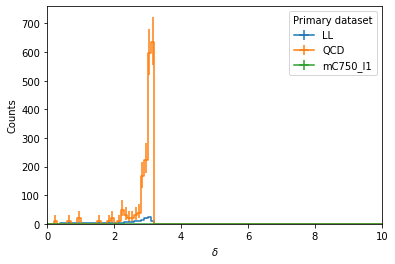

In [35]:
histogram = output['dphiDiFatJet']
ax = hist.plot1d(histogram,overlay="dataset", stack=False)

/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


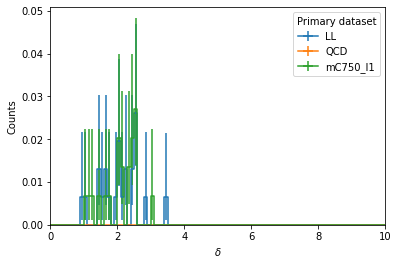

In [36]:
histogram = output['WH_deltaR']
ax = hist.plot1d(histogram,overlay="dataset", stack=False)

In [11]:
from plots.helpers import *
bins = {\
    'N_AK4':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK4 jet}$', 6, -0.5, 5.5)},
    'N_AK4_SR':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK4 jet}$', 6, -0.5, 5.5)},
    'N_AK8':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK8 jet}$', 5, -0.5, 4.5)},
    'N_b':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{b-tag}$', 5, -0.5, 4.5)},
    'N_H':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{H-tag}$', 5, -0.5, 4.5)},
    'N_W':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{W-tag}$', 5, -0.5, 4.5)},

    'MET_pt':   {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', 20, 0, 800)},
    'HT':       {'axis': 'ht',      'overflow':'over',  'bins': hist.Bin('pt', r'$H_{T} (AK4 jets) \ (GeV)$', 25, 0, 2000)},    
    'W_pt':     {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T} (W-tag)$', 8, 200, 600)},
    'W_eta':    {'axis': 'eta',     'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (W-tag)$', 15, -5.5, 5.5)},
    'H_pt':     {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T} (H-tag)$', 8, 200, 600)},
    'H_eta':    {'axis': 'eta',     'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (H-tag)$', 15, -5.5, 5.5)},

    'dphiDiFatJet': {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (AK8)$', 30, 0, 3)},
    'dphiDiJet':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (AK4)$', 30, 0, 3)},
    'WH_deltaPhi':  {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (WH)$', 6, 0, 3)},
    'WH_deltaR':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta R (WH)$', 10, 0, 5)},
    'bb_deltaPhi':  {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (bb)$', 30, 0, 3)},
    'bb_deltaR':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta R (bb)$', 10, 0, 5)},
    'min_dphiJetMet4': {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (j, p_{T}^{miss})$', 30, 0, 3)},
        
    'mtb_min':      {'axis': 'mass',  'overflow':'over',  'bins': hist.Bin('pt', r'$min M_{T} (b, p_{T}^{miss}) \ (GeV)$', 25, 0, 500)},
    'lead_AK8_pt':  {'axis': 'pt',    'overflow':'over',  'bins': hist.Bin('pt', r'$p{T} (lead. AK8) \ (GeV)$', 20, 0, 1000)},
    }

In [12]:
from plots.helpers import *

def saveFig( fig, ax, rax, path, name, scale='linear', shape=False, y_max=-1 ):
    outdir = os.path.join(path,scale)
    finalizePlotDir(outdir)
    ax.set_yscale(scale)
    ax.set_ylabel('Events')

    if scale == 'linear':
        if y_max<0 or True:
            pass
        else:
            ax.set_ylim(0, 1 if shape else 1.2*y_max)
    else:
        if y_max<0 and not shape:
            pass
        else:
            ax.set_ylim(0.000005 if shape else 0.05, 3 if shape else 300*y_max)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for handle, label in zip(handles, labels):
        #print (handle, label)
        try:
            new_labels.append(my_labels[label])
            if not label=='pseudodata':
                handle.set_color(colors[label])
        except:
            pass

    if rax:
        plt.subplots_adjust(hspace=0)
        rax.set_ylabel('Obs./Pred.')
        rax.set_ylim(0.5,1.5)

    ax.legend(title='',ncol=2,handles=handles, labels=new_labels, frameon=False)

    fig.text(0., 0.995, '$\\bf{CMS}$', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.15, 1., '$\\it{Simulation}$', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.8, 1., '13 TeV', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

    fig.savefig(os.path.join(outdir, "{}.pdf".format(name)))
    fig.savefig(os.path.join(outdir, "{}.png".format(name)))
    #ax.clear()

In [13]:
histos = ["met_CR",
          "met_W_CR",
          "met_Higgs_CR"
         ]

/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


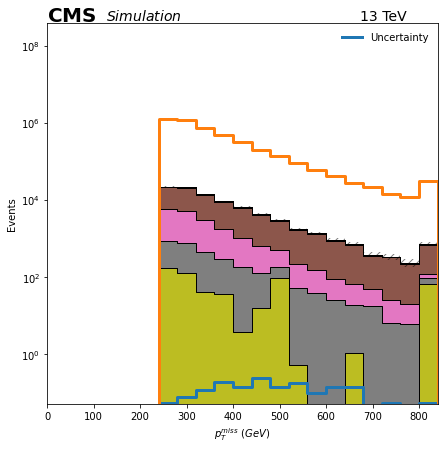

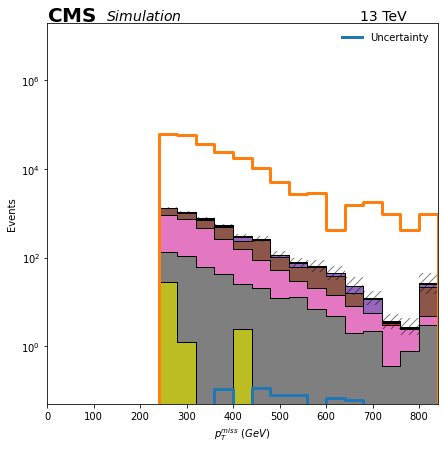

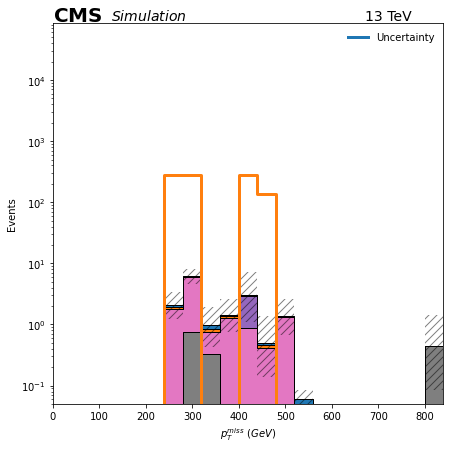

In [18]:
# Make some of the plots

plotDir = '/home/users/ksalyer/public_html/dump/WH_had/'
finalizePlotDir(plotDir)

for name in histos:

    histogram = output[name]

    axis = bins['MET_pt']['axis']
    histogram = histogram.rebin(axis, bins['MET_pt']['bins'])

    y_max = histogram.sum("dataset").values(overflow='all')[()].max()
    y_over = histogram.sum("dataset").values(overflow='all')[()][-1]

    import re
    bkganddata = re.compile('(?!mC750_l1)')
    bkgandsig = re.compile('(?!Data)')

    fig, ax = plt.subplots(1,1,figsize=(7,7))
    
    # get axes
    hist.plot1d(histogram[bkganddata][bkgandsig], overlay="dataset", ax=ax, stack=True, overflow=bins['MET_pt']['overflow'], clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)#, order=['QCD', 'LL']) #error_opts??
    hist.plot1d(histogram['mC750_l1'], overlay="dataset", ax=ax, overflow=bins['MET_pt']['overflow'], line_opts={'linewidth':3}, clear=False)
    hist.plot1d(histogram['Data'], overlay="dataset", ax=ax, overflow=bins['MET_pt']['overflow'], line_opts={'linewidth':3}, clear=False)

    for l in ['log']:
        saveFig(fig, ax, None, plotDir, name, scale=l, shape=False, y_max=y_max)
